<a href="https://colab.research.google.com/github/Viktorydogger/forFEM/blob/master/%D0%9D%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as ma
import sympy as sp

# Функции внутри МКЭ

In [ ]:
def uniform_function(h,p,m,delta,l):
    PD = 2
    q = np.array([[0,0],[l,0],[0,h],[l,h]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, PD])
    a = (q[1,0]-q[0,0])/p
    b = (q[2,1]-q[0,1])/m
    n = 0
    for i in range(1,m+2):
        for j in range(1,p+2):
            NL[n,0] = q[0,0]+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]
            
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
    EL = EL.astype(int)
    NPEn = 3        
    return NL, EL

In [ ]:
def Det2(xi,yi,xj,yj,xk,yk):
    return (xj*(yk - yi) + xi*(yj - yk) + xk*(yi - yj))    

In [ ]:
def K_ok(A,lim):
    for i in range(int(len(lim)/2)):
        if lim[2*i] ==0 and lim[2*i+1] == 0:
            A[2*i:2*i+1,:]=A[2*i:2*i+1,:]*0
            A[:,2*i:2*i+1]=A[:,2*i:2*i+1]*0
            A[2*i,2*i] = 1
            A[2*i+1,2*i+1] = 1
    return A

In [ ]:
def make_B(num,el_nod,Coord_nod,D):
    x,y,z = sp.symbols('x, y, z')
    ui,uj,uk = sp.var('ui uj uk')
    vi,vj,vk = sp.var('vi vj vk')
    wi,wj,wk = sp.var('wi wj wk')
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    # для конкретного элемента ищем координаты узлов
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    # пользуемся формулами со слайда 29
    Det = Det2(xi,yi,xj,yj,xk,yk)
    ai = (xj*yk - xk*yj)/Det
    aj = (xk*yi - xi*yk)/Det
    ak = (xi*yj - xj*yi)/Det
    bi = (yj - yk)/Det
    bj = (yk - yi)/Det
    bk = (yi - yj)/Det
    ci = (xk - xj)/Det
    cj = (xi - xk)/Det
    ck = (xj - xi)/Det
    # собираем матрицу B
    Bi =[[bi, 0],[0, ci],[ci, bi]]
    Bj =[[bj, 0],[0, cj],[cj, bj]] 
    Bk =[[bk, 0],[0, ck],[ck, bk]] 
    B0 = np.hstack([Bi, Bj, Bk])
    return B0

In [ ]:
def make_K(num,el_nod,Coord_nod,D):
    Bi = make_B(num,el_nod,Coord_nod,D)
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    return (Det2(xi,yi,xj,yj,xk,yk)/2)*Bi.T.dot(D).dot(Bi)

In [ ]:
def sum_K(A,B,ind,num):
    for i in range(len(ind)):
        for j in range(len(ind)):
            ii = ind[i]
            jj = ind[j]
            A[ii*2:ii*2+2,jj*2:jj*2+2] += B[i*2:i*2+2,j*2:j*2+2]
    return A

In [ ]:
def right(eff,num_nod):
    a = np.zeros(num_nod*2)
    for i in range(len(eff)):
            a[i*2] = eff[i,0]
            a[i*2+1] = eff[i,1]       
    return a

In [ ]:
def paint(cord,elem):
    x0, y0 = cord[elem[:,0]-1,0], cord[elem[:,0]-1,1]
    x1, y1 = cord[elem[:,1]-1,0], cord[elem[:,1]-1,1]
    x2, y2 = cord[elem[:,2]-1,0], cord[elem[:,2]-1,1]
    plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
    plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
    plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
    plt.grid()
    return 

In [ ]:
def FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,l):
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D),ind,i)
    for i in range(Num_nod):
        if abs(Coord_nod[i,0])<1/(p*m*1000):
            K0[i*2,:] = K0[i,:]*0
            K0[:,2*i] = K0[:,i]*0
            K0[i*2,i*2] = 1    
    U = np.linalg.solve(K0,rig.T)
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    lnap = np.matrix([-1,-1,-1])
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1]    
        Eps = B.dot(Ui)
        Nap = D.dot(Eps) 
        lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])  
        now_sig = Nap[0]      
        #Sig,s = np.linalg.eig(NapM)         
        #now_sig = ma.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        print(now_sig)
        if now_sig > max_sig:
            max_sig = now_sig
            max_sig_i = i 
    print("Максимальное напряжение = ",max_sig)
    a = Coord_nod[el_nod[max_sig_i,0],:]
    b = Coord_nod[el_nod[max_sig_i,1],:]
    c = Coord_nod[el_nod[max_sig_i,2],:]
    print("Количество элементов ", len(el_nod))
    plt.grid()
    e = plt.Polygon([a,b,c],color='red')
    plt.gca().add_patch(e)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(b[0],b[1],'r*')
    plt.plot(a[0],a[1],'r*')
    plt.plot(c[0],c[1],'r*')
    plt.axis('equal')
    plt.show()
    plt.close()
    lnap = np.delete(lnap,0,axis = 0)
    return U

# Стандартный МКЭ

4545454.545451687
4545454.545453523
4545454.545451773
4545454.545453539
4545454.54545179
4545454.545453542
4545454.545451785
4545454.545453527
4545454.545451768
4545454.545453524
4545454.545451759
4545454.5454535065
4545454.545451741
4545454.545453499
4545454.545451718
4545454.54545348
4545454.545451682
4545454.545453466
4545454.545451659
4545454.545453475
4545454.545451624
4545454.545453452
4545454.545451608
4545454.54545347
4545454.5454515815
4545454.545453424
4545454.545451549
4545454.545453436
4545454.545451518
4545454.545453388
4545454.545451481
4545454.5454533575
4545454.545451446
4545454.545453319
4545454.545451431
4545454.545453346
4545454.545451388
4545454.545453316
4545454.545451322
4545454.545453273
4545454.545451307
4545454.545453298
4545454.545451288
4545454.5454532225
4545454.545451232
4545454.54545322
4545454.5454512
4545454.545453239
4545454.545451145
4545454.545453208
4545454.545451145
4545454.545453198
4545454.545451087
4545454.545453198
4545454.545451066
4545454.5454

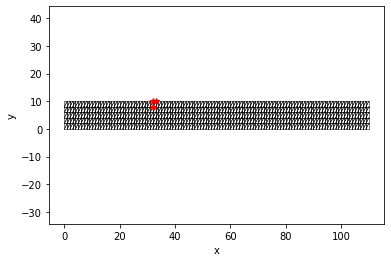

In [ ]:
mu = 0.3
E = 2.1*10**11
h = 10
p = 110
m = 5
delta = 0.5
l = 11*h
element_type = 'D2TR3N'
NL, EL = uniform_function(h,p,m,delta,l)
paint(NL,EL)
EL = EL - np.ones((EL.shape[0],EL.shape[1]))
EL = EL.astype(int)
q = 100*10**6
eff = np.zeros((len(NL),2))
for i in range(len(NL)):
    if NL[i,0] >= l:
        if NL[i,1] >= h or NL[i,1] == 0:
            eff[i,0] = h*q/p/2
        else: 
            eff[i,0] = h*q/p
#D = E/(1 - mu*mu)*np.array([[1,mu,0],[mu,1,0],[0,0, (1-mu)/2]])
D = E*(1-mu)/((1+mu)*(1-2*mu))*np.array([[1,mu/(1-mu),0],[mu/(1-mu),1,0],[0,0,(1-2*mu)/(2*(1-mu))]])
U = FEM(EL,NL,D,eff,len(NL),len(EL),l)

In [ ]:
print(U)

[ 0.00000000e+00 -1.74376545e-04  1.96969697e-05 ... -2.58792130e-04
  2.16666667e-03 -2.58792130e-04]


# Функции для построения локальной сетки

Сетка для прямоугольника

In [ ]:
def uniform_function_(x0,y0,d1,d2,p,m):
    PD = 2
    q = np.array([[x0,y0],[x0+d1,y0],[x0,y0+d2],[x0+d1,y0+d2]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, PD])
    a = (q[1,0]-q[0,0])/p
    b = (q[2,1]-q[0,1])/m
    n = 0
    for i in range(1,m+2):
        for j in range(1,p+2):
            NL[n,0] = q[0,0]+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]
            
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
        
    EL = EL.astype(int)
    NPEn = 3
    count2 = 1
    #for j in range(0,NoE*2):
     #   plt.annotate(count2,xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3,(NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3),c = 'blue')
      #  count2 += 1
    return NL, EL

сетка с правым краем по окружности 

In [ ]:
def half_circle1(x0,y0,delta,w,p,m):
    q = np.array([[x0,y0],[x0+w,y0],[x0+w-delta,y0+delta],[x0+w,y0+delta]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, 2])
    b = delta/m
    n = 0
    for i in range(1,m+2):
        a = ( w - ma.sqrt(delta**2-((m+1-i)*b)**2))/p 
        for j in range(1,p+2):
            NL[n,0] = q[0,0]+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]   
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
        
    EL = EL.astype(int)
    NPEn = 3
    count2 = 1
   # for j in range(0,NoE*2):
    #    plt.annotate(count2,xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3,(NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3),c = 'blue')
     #   count2 += 1
    return NL, EL

сетка с левым краем по окружности

In [ ]:
def half_circle2(x0,y0,delta,w,p,m):
    q = np.array([[x0,y0],[x0+w,y0],[x0,y0+delta],[x0+w,y0+delta]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, 2])
    b = delta/m
    n = 0
    
    for i in range(1,m+2):
        a = (w-ma.sqrt(delta**2-((m+1-i)*b)**2))/p 
        st = ma.sqrt(delta**2-((m+1-i)*b)**2)
        for j in range(1,p+2):
            NL[n,0] = x0+st+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]   
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
        
    EL = EL.astype(int)
    NPEn = 3
    count2 = 1
   # for j in range(0,NoE*2):
    #    plt.annotate(count2,xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3,(NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3),c = 'blue')
     #   count2 += 1
    return NL, EL

In [ ]:
def local_mesh(r,lef,w,top,deep):
    p=2
    m=4
    #количество разбиений на горизонтальных гранях
    Yn = w/(1.5*r)
    # область I и симметричная ей I' заполняются как преямоугольники, но надо учесть, что они не у начала координат
    NLI,ELI = uniform_function_(lef,top-deep,w/2-r,deep,p,m)
    NLI1,ELI1 = uniform_function_(lef+w/2+r,top-deep,w/2-r,deep,p,m)
    len_of_NLI = len(NLI)
    len_of_ELI = len(ELI)
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-deep-r,r,w,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-deep-r,r,w,p,m)
    len_of_NLII = len(NLII)
    len_of_ELII = len(ELII)
    # область III заполняется как прямоугольник
    NLIII,ELIII = uniform_function_(lef,top-2,w,2*w+w-deep-r,p*2,m*3)
    len_of_NLIII = len(NLIII)
    len_of_ELIII = len(ELIII)
    #нужно соединить все сектора в одну сетку
    #из добавляемого массива координат удаляем те, которые уже есть, запоминаем их номера из массива, к которому добавляем. 
    #в массиве номеров узлов по элементам, удалённым узлам присваиваем номера в соответсвии с теми, что запомнили
    ss = set()
    ss1 = set()
    for i in range(len_of_NLI):
        for j in range(len_of_NLII):
            if abs(NLI[i,0]-NLII[j,0])<delta/1000 and abs(NLI[i,1]-NLII[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)
    ss = list(ss)
    ss1 = list(ss1)
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLII = np.delete(NLII,ss2,axis=0)
    for i in range(len_of_ELII):
        for j in range(3):
            if ELII[i,j] in ss1:
                for k in range(len(ss1)):
                    if ELII[i,j] == ss1[k]:
                        ELII[i,j] = ss[k]
            elif ELII[i,j] > max(ss1):
                ELII[i,j] += len_of_NLI - len(ss)
            else: ELII[i,j] += len_of_NLI
    EL = np.vstack([ELI,ELII])            
    NL = np.vstack([NLI,NLII])
    ss = set()
    ss1 = set()
    for i in range(len(NL)):
        for j in range(len_of_NLIII):
            if abs(NL[i,0]-NLIII[j,0])<delta/1000 and abs(NL[i,1]-NLIII[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)
    ss = list(ss)
    ss1 = list(ss1)
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLIII = np.delete(NLIII,ss2,axis=0)
    for i in range(len_of_ELIII):
        for j in range(3):
            if ELIII[i,j] in ss1:
                 for k in range(len(ss1)):
                        if ELIII[i,j] == ss1[k]:
                            ELIII[i,j] = ss[k]
            elif ELIII[i,j] > max(ss1):
                ELIII[i,j] += len(NL) - len(ss)
            else: ELIII[i,j] += len(NL)
    EL = np.vstack([EL,ELIII])            
    NL = np.vstack([NL,NLIII])
    ss = set()
    ss1 = set()
    for i in range(len(NL)):
        for j in range(len_of_NLII):
            if abs(NL[i,0]-NLII1[j,0])<delta/1000 and abs(NL[i,1]-NLII1[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)
    ss = list(ss)
    ss1 = list(ss1)
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLII1 = np.delete(NLII1,ss2,axis=0)
    for i in range(len_of_ELII):
        for j in range(3):
            if ELII1[i,j] in ss1:
                 for k in range(len(ss1)):
                        if ELII1[i,j] == ss1[k]:
                            ELII1[i,j] = ss[k]
            elif ELII1[i,j] > max(ss1):
                ELII1[i,j] += len(NL) - len(ss)
            else: ELII1[i,j] += len(NL)
    EL = np.vstack([EL,ELII1])            
    NL = np.vstack([NL,NLII1])   
    ss = set()
    ss1 = set()
    for i in range(len(NL)):
        for j in range(len_of_NLI):
            if abs(NL[i,0]-NLI1[j,0])<delta/1000 and abs(NL[i,1]-NLI1[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)
    ss = list(ss)
    ss1 = list(ss1)
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLI1 = np.delete(NLI1,ss2,axis=0)
    for i in range(len_of_ELI):
        for j in range(3):
            if ELI1[i,j] in ss1:
                 for k in range(len(ss1)):
                        if ELI1[i,j] == ss1[k]:
                            ELI1[i,j] = ss[k]
            elif ELI1[i,j] > max(ss1):
                ELI1[i,j] += len(NL) - len(ss)
            else: ELI1[i,j] += len(NL)
    EL = np.vstack([EL,ELI1])            
    NL = np.vstack([NL,NLI1])

   # for i in range(len(NL)):
   #     plt.annotate(i,xy = (NL[i,0],NL[i,1]))
    paint(NL,EL)
    return NL,EL

Код для окончания дефекта (только полукруг, глубина не учитывается)

In [ ]:
def local_mesh_without_deep(r,lef,top,w):
    p=2
    m=3
    #количество разбиений на горизонтальных гранях
    Yn = w/(1.5*r)
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-r,r,w/2,p,m)
    #def half_circle1(x0,y0,delta,h,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-r,r,w/2,p,m)
    len_of_NLII = len(NLII)
    len_of_ELII = len(ELII)
    #paint(NLII1,ELII1)
    #paint(NLII,ELII)
    # область III заполняется как прямоугольник
    NLa,ELa = uniform_function_(lef,top-2,w,w-r,p*2,m*2)
    NLb,ELb = uniform_function_(lef,top-6,w,w*2,p*2,m*2*4)

    ss = set()
    ss1 = set()
    for i in range(len(NLa)):
        for j in range(len(NLb)):
            if abs(NLa[i,0]-NLb[j,0])<delta/1000 and abs(NLa[i,1]-NLb[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)     
    ss = list(ss)
    ss1 = list(ss1)
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLb = np.delete(NLb,ss2,axis=0)
    for i in range(len(ELb)):
        for j in range(3):
            if ELb[i,j] in ss1:
                 for k in range(len(ss1)):
                        if ELb[i,j] == ss1[k]:
                            ELb[i,j] = ss[k]
            elif ELb[i,j] > max(ss1):
                ELb[i,j] += len(NLa) - len(ss)
            else: ELb[i,j] += len(NLa)
    ELIII = np.vstack([ELa,ELb])            
    NLIII = np.vstack([NLa,NLb])




    len_of_NLIII = len(NLIII)
    len_of_ELIII = len(ELIII)
    
    #нужно соединить все сектора в одну сетку
    #из добавляемого массива координат удаляем те, которые уже есть, запоминаем их номера из массива, к которому добавляем. 
    #в массиве номеров узлов по элементам, удалённым узлам присваиваем номера в соответсвии с теми, что запомнили
    ss = set()
    ss1 = set()
    for i in range(len_of_NLII):
        for j in range(len_of_NLIII):
            if abs(NLII[i,0]-NLIII[j,0])<delta/1000 and abs(NLII[i,1]-NLIII[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)
                
    ss = list(ss)
    ss1 = list(ss1)
    
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLIII = np.delete(NLIII,ss2,axis=0)
    for i in range(len_of_ELIII):
        for j in range(3):
            if ELIII[i,j] in ss1:
                 for k in range(len(ss1)):
                        if ELIII[i,j] == ss1[k]:
                            ELIII[i,j] = ss[k]
            elif ELIII[i,j] > max(ss1):
                ELIII[i,j] += len_of_NLII - len(ss)
            else: ELIII[i,j] += len_of_NLII
    EL = np.vstack([ELII,ELIII])            
    NL = np.vstack([NLII,NLIII])
    ss = set()
    ss1 = set()
    for i in range(len(NL)):
        for j in range(len_of_NLII):
            if abs(NL[i,0]-NLII1[j,0])<delta/1000 and abs(NL[i,1]-NLII1[j,1])<delta/1000:
                ss.add(i+1)
                ss1.add(j+1)
    ss = list(ss)
    ss1 = list(ss1)
    ss.sort()
    ss1.sort()
    ss2 = list(np.array(ss1)-1)
    NLII1 = np.delete(NLII1,ss2,axis=0)
    for i in range(len_of_ELII):
        for j in range(3):
            if ELII1[i,j] in ss1:
                 for k in range(len(ss1)):
                        if ELII1[i,j] == ss1[k]:
                            ELII1[i,j] = ss[k]
                            break
            elif ELII1[i,j] > max(ss1):
                ELII1[i,j] += len(NL) - len(ss)
            else: ELII1[i,j] += len(NL)
    EL = np.vstack([EL,ELII1])            
    NL = np.vstack([NL,NLII1])   
    
   # for i in range(len(NL)):
   #     plt.annotate(i,xy = (NL[i,0],NL[i,1]))
    paint(NL,EL)
    return NL,EL
    

#Подробное описание функций выше



1. uniform_function_(x0,y0,d1,d2,p,m)
Задаёт сетку для прямоугольника.
*   x0 - координата по горизонтали левой нижней точки прямоугольника 
*   y0 - координата по вертикали левой нижней точки прямоугольника 
*  d1 - ширина прямоугольника 
* d2 - высота прямоугольника
* p - количество элементов по горизонтали 
* m - количество элементов по вертикали 
2. half_circle1(x0,y0,r,w,p,m)
Задаёт сетку на четырёхугольнике, где правая сторона - четверть дуги
* x0 - координата по горизонтали левой нижней точки
* y0 - координата по вертикали левой нижней точки
* w - максимальная ширина четырёхугольника
* r - радиус дуги
* p - количество элементов по горизонтали 
* m - количество элементов по вертикали 
3. half_circle2(x0,y0,delta,w,p,m)
Задаёт сетку на четырёхугольнике, где левая сторона - четверть дуги
* x0 - координата по горизонтали левой нижней точки
* y0 - координата по вертикали левой нижней точки
* w - максимальная ширина четырёхугольника
* r - радиус дуги
* p - количество элементов по горизонтали 
* m - количество элементов по вертикали
4. local_mesh_without_deep(r,lef,top,w)
Разбивает !квадрат! на локальную сетку, если у дефекта ещё нет глубины
* r - радиус дефекта
* lef - координата левой границы квадрата
* top - верхняя граница квадрата
* w - длина стороны квадрата
5. local_mesh(r,lef,w,top,deep)
Разбивает !квадрат! на локальную сетку
* r - радиус дефекта
* lef - координата левой границы квадрата
* top - верхняя граница квадрата
* w - длина стороны квадрата
* deep - глубина деекта без учёта радиуса



# Новая(правильная) локальная сетка

Проблема: нужно, чтобы учитвались все узлы из старой сетки (решено)

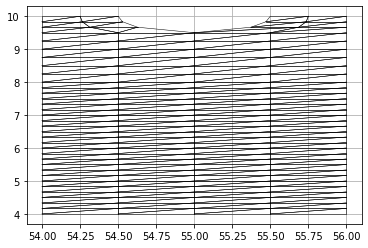

In [ ]:
#начальная глубина равна 0
deep = 0
#считаем, на сколько квадратов надо уйти в глубину
sqcount = ma.ceil(deep)
#обозначаем боковые границы элементов, которых касается дефект
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
#проверим есть ли такие узлы в глобальной сетке
#for c in NL:
 # if c[0]==left_b:
  #  print('its left ',c)
  #elif c[0]==right_b:
   # print('its right ',c)

if deep == 0: 
  NLgl,ELgl = local_mesh_without_deep(delta,left_b,h,h/5)

# Глобальный МКЭ с локальным и глобальным решением 

In [ ]:
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
ln = len(NLgl)
le = len(ELgl)
Ugl = np.zeros((ln*2,1))
for i in range(len(NL)):
    if abs(left_b-NL[i,0])<h/1000 or abs(right_b-NL[i,0])<h/1000:
        for j in range(ln):
        
          if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
              #print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1])
              Ugl[j*2] = U[i*2]
              Ugl[j*2+1] = U[i*2+1]
#print(Ugl)

54.0 54.0 4.0 4.0
56.0 56.0 4.0 4.0
54.0 54.0 6.0 6.0
56.0 56.0 6.0 6.0
54.0 54.0 8.0 8.0
56.0 56.0 8.0 8.0
54.0 54.0 10.0 10.0
56.0 56.0 10.0 10.0


In [ ]:
K0 = np.zeros((ln*2,ln*2))
for i in range(0,le):
    ind = ELgl[i,:]
    K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)

In [ ]:
rig = np.zeros((1,ln*2))
#нулевой вектор правой части
rig1 = K0.dot(Ugl)
#вектор правой части после умножения на вектор известных премещений
for i in range(2*ln): #учёт нулей
    if abs(Ugl[i])>0:
        K0[i,:] = K0[i,:]*0
        K0[:,i] = K0[:,i]*0
        K0[i,i] = 1
        rig1[i] = 0
Ufin = np.linalg.solve(K0,-rig1)
#print(len(Ugl),len(Ufin))
#for i in range(len(Ufin)):
 #   print(Ugl[i],Ufin[i])
Ufin = Ufin+Ugl

Напряжение в элементах, узлом которых, является нижняя точка окружности:
2092904.6891827686
826846.8490776467
1597897.8250390135
1810471.653798533
985051.8527914339
1427083.6659378316
sigmamax =  6294742.025426157
[54.          5.83333333] [54.5  6. ] [54.  6.]
Количество элементов  264


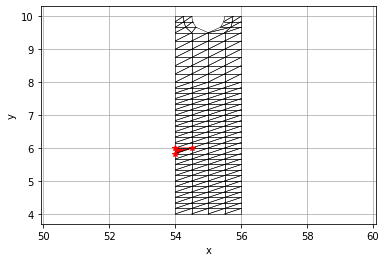

In [ ]:
lnap = np.matrix([-1,-1,-1])
max_sig = 0
max_sig_i = -1
m_s=0
m_s_i=-1
print("Напряжение в элементах, узлом которых, является нижняя точка окружности:")
for i in range(le):
    B = make_B(i,ELgl,NLgl,D)
    Ui = np.zeros((6))
    Ui[0] = Ufin[ELgl[i,0]*2]
    Ui[1] = Ufin[ELgl[i,0]*2+1]
    Ui[2] = Ufin[ELgl[i,1]*2]
    Ui[3] = Ufin[ELgl[i,1]*2+1]  
    Ui[4] = Ufin[ELgl[i,2]*2]
    Ui[5] = Ufin[ELgl[i,2]*2+1]#деформации (эпсилон)    
    Eps = B.dot(Ui)    # напряжения(сигма)
    Nap = D.dot(Eps) 
    lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
    NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]]) 
    now_sig = Nap[0]
    #Sig,s = np.linalg.eig(NapM)         
    #now_sig = ma.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
    if(NLgl[ELgl[i,2],0]==55 and NLgl[ELgl[i,2],1]==10-delta ):
      print(now_sig)
    if(NLgl[ELgl[i,1],0]==55 and NLgl[ELgl[i,1],1]==10-delta ):
      print( now_sig)
    if(NLgl[ELgl[i,0],0]==55 and NLgl[ELgl[i,0],1]==10-delta ):
      print(now_sig)
    if now_sig > max_sig:
        max_sig = now_sig
        max_sig_i = i
    
print("sigmamax = ",max_sig)
a = NLgl[ELgl[max_sig_i,0],:]
b = NLgl[ELgl[max_sig_i,1],:]
c = NLgl[ELgl[max_sig_i,2],:]
print(a,b,c)
ELgl = ELgl + np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
x0, y0 = NLgl[ELgl[:,0]-1,0], NLgl[ELgl[:,0]-1,1]
x1, y1 = NLgl[ELgl[:,1]-1,0], NLgl[ELgl[:,1]-1,1]
x2, y2 = NLgl[ELgl[:,2]-1,0], NLgl[ELgl[:,2]-1,1]
plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
plt.axis('equal')
lnap = np.delete(lnap,0,axis = 0)
print("Количество элементов ", le)
plt.grid()
e = plt.Polygon([a,b,c],color='red')
plt.gca().add_patch(e)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(b[0],b[1],'r*')
plt.plot(a[0],a[1],'r*')
plt.plot(c[0],c[1],'r*')  
plt.axis('equal')
plt.show()
plt.close()
lnap = np.delete(lnap,0,axis = 0)
  

# Динамика роста дефекта


Алгоритм решения задачи для фиксированной начальной геометрии:
1 построение геометрии, задание свойств материала;
2 разбиение на конечные элементы, расчет напряжений; (полный цикл – глобальная, локальная задача + итерации до «сходимости»)
3 определение напряжений (maximum principal stress = stress_K) в нижней точке дефекта;
4 расчет скорости роста дефекта на данном шаге по формуле V_k=(а+m*stress_k);
5 расчет глубины на следующем шаге по формуле S_i=S_(i-1) + V_(i-1)*t где t – временной шаг;
6 построение геометрии следующего шага – с изменившейся глубиной;
7 переход к шагу 2 в цикле, цикл работает до тех пор пока полная глубина дефекта (сфера+цилиндр) S_i на каком-то шаге не станет >= h/2.


In [ ]:
def iteration_deep(ms,now_deep):
  a = 0.1
  m = 0.0008
  Vk = a+m*ms
  Si = now_deep + t*Vk
  return Si


# Новый раздел